In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_auc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_recall_curve, average_precision_score

def evaluate_classification(y_true, y_pred, y_prob):
    # Select the probabilities of the positive class
    y_prob_positive = y_prob[:, 1]
    
    plot_confusion_matrix(y_true, y_pred)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    precision, recall, _ = precision_recall_curve(y_true, y_prob_positive)
    ap = average_precision_score(y_true, y_prob_positive)
    print(f"Average Precision: {ap:.4f}")
    
    plot_roc_auc_curve(y_true, y_prob_positive)


In [2]:
data = pd.read_csv('./data/Sampled_data_train.csv')
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3493085.0,0.0,13264386.0,314.950,W,1444.0,490.0,150.0,visa,166.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing
1,3520085.0,0.0,14052685.0,117.000,W,3681.0,513.0,150.0,visa,166.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing
2,3329023.0,0.0,8439647.0,92.745,C,3335.0,545.0,185.0,visa,138.0,...,ie 11.0 for desktop,-1.0,missing,missing,F,T,T,F,desktop,Trident/7.0
3,3408925.0,0.0,10689293.0,200.000,R,12607.0,399.0,150.0,american express,185.0,...,chrome 65.0,24.0,1600x900,match_status:2,T,F,T,F,desktop,Windows
4,3075828.0,0.0,1874266.0,226.000,W,10795.0,555.0,150.0,visa,226.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing


In [3]:
X = data.drop(['TransactionID','isFraud'],axis = 1)
y = data['isFraud']

In [4]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3 , stratify = y, random_state = 42)

X_train.shape , y_train.shape , X_test.shape , y_test.shape #, X_val.shape , y_val.shape

((70000, 432), (70000,), (30000, 432), (30000,))

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define the numerical and categorical column names

# Get the data types of each column
dtypes = X_train.dtypes

# Find the numerical columns
numerical_cols = dtypes[dtypes != 'object'].index.tolist()

# Find the categorical columns
categorical_cols = dtypes[dtypes == 'object'].index.tolist()

# Define the column transformer for scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [6]:
# Transform the data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


**Logistic Regression**

In [7]:
# Load the model from the file
with open("logistic_regression_tuned.pkl", "rb") as f:
    lr = pickle.load(f)


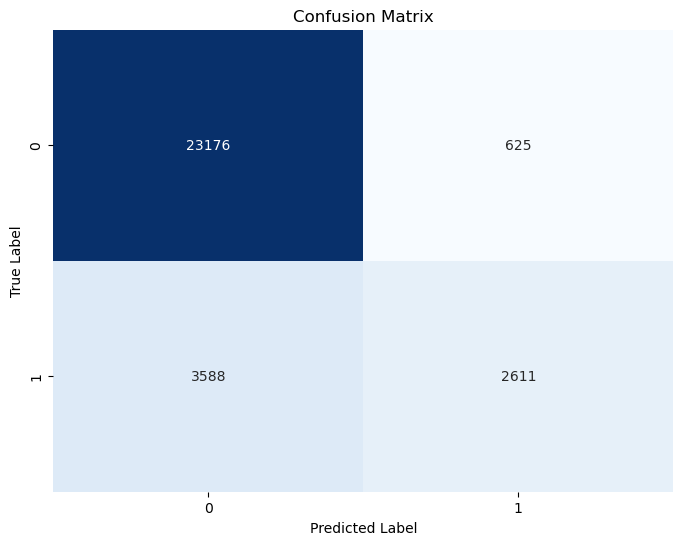

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     23801
         1.0       0.81      0.42      0.55      6199

    accuracy                           0.86     30000
   macro avg       0.84      0.70      0.74     30000
weighted avg       0.85      0.86      0.84     30000

Cohen's Kappa: 0.4797
Matthews Correlation Coefficient: 0.5155
Average Precision: 0.6952


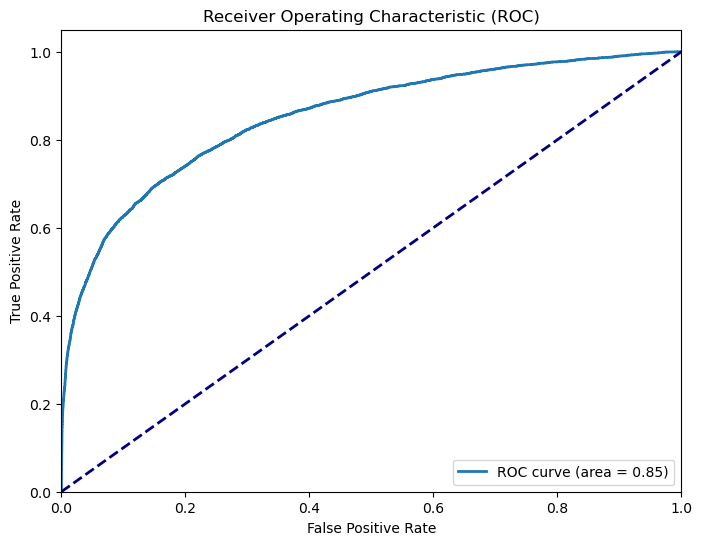

In [8]:
# Assuming you already have y_true, y_pred, and y_prob from your model

y_true = y_test
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)
evaluate_classification(y_true, y_pred, y_prob)


**XGBoost f1 score**

In [9]:
# Load the model from the file
with open("xgb_best_f1_score.pkl", "rb") as f:
    xgb = pickle.load(f)


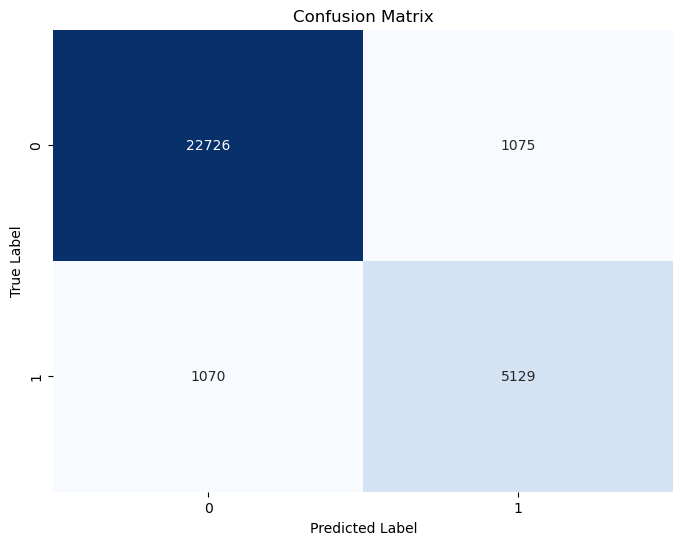

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     23801
         1.0       0.83      0.83      0.83      6199

    accuracy                           0.93     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.93      0.93      0.93     30000

Cohen's Kappa: 0.7820
Matthews Correlation Coefficient: 0.7820
Average Precision: 0.9103


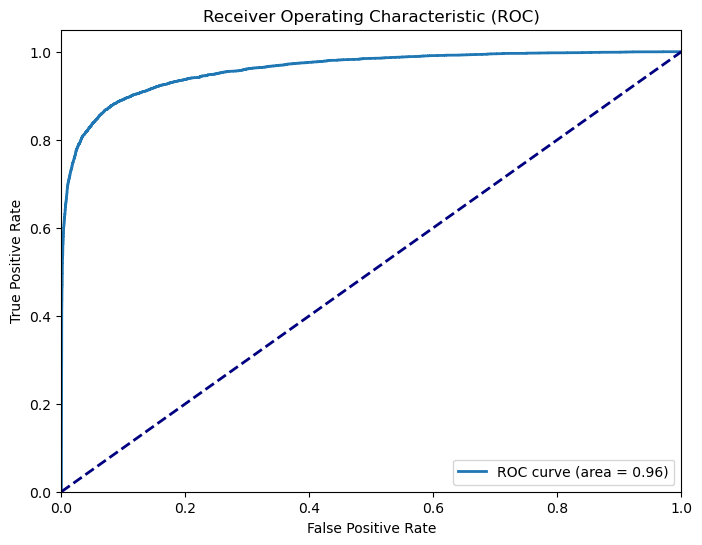

In [10]:

y_true = y_test
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
evaluate_classification(y_true, y_pred, y_prob)


**XGBoost auc score**

In [11]:
# Load the model from the file
with open("xgb_best_auc.pkl", "rb") as f:
    xgb = pickle.load(f)


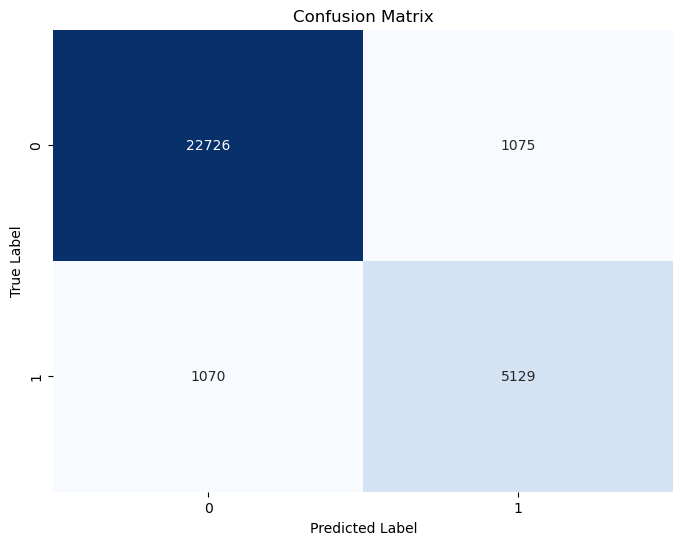

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     23801
         1.0       0.83      0.83      0.83      6199

    accuracy                           0.93     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.93      0.93      0.93     30000

Cohen's Kappa: 0.7820
Matthews Correlation Coefficient: 0.7820
Average Precision: 0.9103


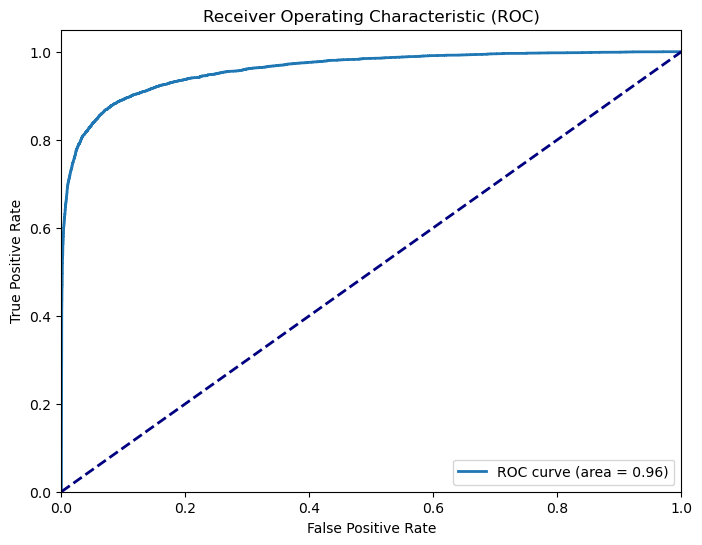

In [12]:

y_true = y_test
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
evaluate_classification(y_true, y_pred, y_prob)
